In [1]:
import sys

sys.path.insert(0, "..")

from dinov2.data.loaders import make_dataset
import matplotlib.pyplot as plt
from dinov2.data import DataAugmentationDINO

import numpy as np
import torch

from dinov2.data.masking import MaskingGenerator
from dinov2.data.collate import collate_data_and_cast
from dinov2.data import make_data_loader

from functools import partial

from dinov2.models.vision_transformer import DinoVisionTransformer

from dinov2.layers import (
    MemEffAttention,
    Mlp,
    PatchEmbed,
    SwiGLUFFNFused,
)
from dinov2.layers import (
    NestedTensorBlock as Block,
)


root = "/home/jluesch/Documents/data/plankton/ankita_test_1mio_lmdb/"
ds_path = f"LMDBDataset:split=TRAIN:root={root}:extra=*"

/home/jluesch/Documents/GitHub/plankton-dinov2/notebooks/../dinov2/layers/attention.py:29: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/jluesch/Documents/GitHub/plankton-dinov2/notebooks/../dinov2/layers/block.py:34: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/home/jluesch/Documents/GitHub/plankton-dinov2/notebooks/../dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")


In [2]:
global_crops_size = 224
local_crops_size = 98
patch_size = 14

do_seg_crops = "slic"
na_vit = True
data_transform_cpu = DataAugmentationDINO(
    global_crops_scale=[0.32, 0.8],
    local_crops_scale=[0.05, 0.32],
    local_crops_number=6,
    global_crops_size=global_crops_size,
    local_crops_size=local_crops_size,
    use_kornia=True,
    use_native_res=na_vit,
    do_seg_crops=do_seg_crops,
    patch_size=patch_size,
)

dataset = make_dataset(
    dataset_str=ds_path,
    transform=data_transform_cpu,
    target_transform=lambda x: (),
    with_targets=False,
    cache_dataset=False,
)

Dataset kwargs {'split': <_Split.TRAIN: 'train'>, 'root': '/home/jluesch/Documents/data/plankton/ankita_test_1mio_lmdb/', 'extra': '*'}
extra_path /home/jluesch/Documents/data/plankton/ankita_test_1mio_lmdb/*-TRAIN_*
Datasets labels file list:  []
Datasets imgs file list:  ['/home/jluesch/Documents/data/plankton/ankita_test_1mio_lmdb/helgoland_2020-TRAIN_imgs']
aaaa
/home/jluesch/Documents/data/plankton/ankita_test_1mio_lmdb/helgoland_2020-TRAIN_imgs lmdb_env_imgs.stat() {'psize': 4096, 'depth': 3, 'branch_pages': 67, 'leaf_pages': 12514, 'overflow_pages': 4525829, 'entries': 1186534}


UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 1: invalid start byte

In [17]:
nb_patches_gc = global_crops_size // patch_size

mask_generator = MaskingGenerator(
    input_size=(nb_patches_gc, nb_patches_gc),
    max_num_patches=0.5 * nb_patches_gc * nb_patches_gc,
)

def list_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

n_tokens = (global_crops_size // patch_size) ** 2
collate_fn = partial(
    collate_data_and_cast,
    mask_ratio_tuple=(0.1, 0.5),
    mask_probability=0.5,
    n_tokens=n_tokens,
    mask_generator=mask_generator,
    dtype=torch.half,
    free_shapes=do_seg_crops,
)

data_loader = make_data_loader(
    dataset=dataset,
    batch_size=16,
    num_workers=8,
    shuffle=True,
    seed=0,
    sampler_type=None,
    sampler_advance=0,
    drop_last=True,
    collate_fn=collate_fn,
)

In [8]:
model = DinoVisionTransformer(
    patch_size=patch_size,
    embed_dim=384,
    depth=12,
    num_heads=6,
    mlp_ratio=4,
    block_fn=partial(Block, attn_class=MemEffAttention),
    num_register_tokens=0,
    img_size=global_crops_size,
    in_chans=3,
    drop_path_rate=0.0,
    drop_path_uniform=True,
    init_values=1.0e-05,  # for layerscale: None or 0 => no layerscale
    embed_layer=PatchEmbed,
    ffn_layer="mlp",
    block_chunks=1,
    interpolate_antialias=False,
    interpolate_offset=0.1,
    free_shapes=na_vit,
    num_loc_crops=6,
)

In [9]:
mem_list, max_mem_list, shapes_list_gc, shapes_list_lc = [], [], [], []
model.cuda()
with torch.cuda.amp.autocast():
    with torch.no_grad():
        for i, el in enumerate(data_loader):
            if not i % 25:
                print(i)
            if i > 3:
                break
            if isinstance(el, list):
                el = el[0]
            if isinstance(el, dict):
                collated_dict = el

            # list of len batch size containing dicts
            # collated_dict = collate_fn(el)

            mem_list.append(np.round(torch.cuda.memory_allocated() / 1024 / 1024, 2))
            max_mem_list.append(
                np.round(torch.cuda.max_memory_allocated() / 1024 / 1024, 2)
            )
            shapes_list_gc.append(collated_dict["collated_global_crops"].size(-1) / 14)
            shapes_list_lc.append(collated_dict["collated_local_crops"].size(-1) / 14)

            out = model(
                [
                    collated_dict["collated_global_crops"].cuda(),
                    collated_dict["collated_local_crops"].cuda(),
                ],
                masks=[collated_dict["collated_masks"].cuda(), None],
                is_training=True,
                # attn_masks=[collated_dict["attn_mask_gc"].cuda(),collated_dict["attn_mask_lc"].cuda()]
            )
            #'x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'
            print(
                "out gc",
                out[0]["x_norm_clstoken"].shape,
                out[0]["x_norm_patchtokens"].shape,
            )
            print(
                "out lc",
                out[1]["x_norm_clstoken"].shape,
                out[1]["x_norm_patchtokens"].shape,
            )

            out = model(
                collated_dict["collated_global_crops"].cuda(),
                masks=collated_dict["collated_masks"].cuda(),
                is_training=True,
                # attn_masks=[collated_dict["attn_mask_gc"].cuda(),collated_dict["attn_mask_lc"].cuda()]
            )

            print("out gc", out["x_norm_clstoken"].shape)

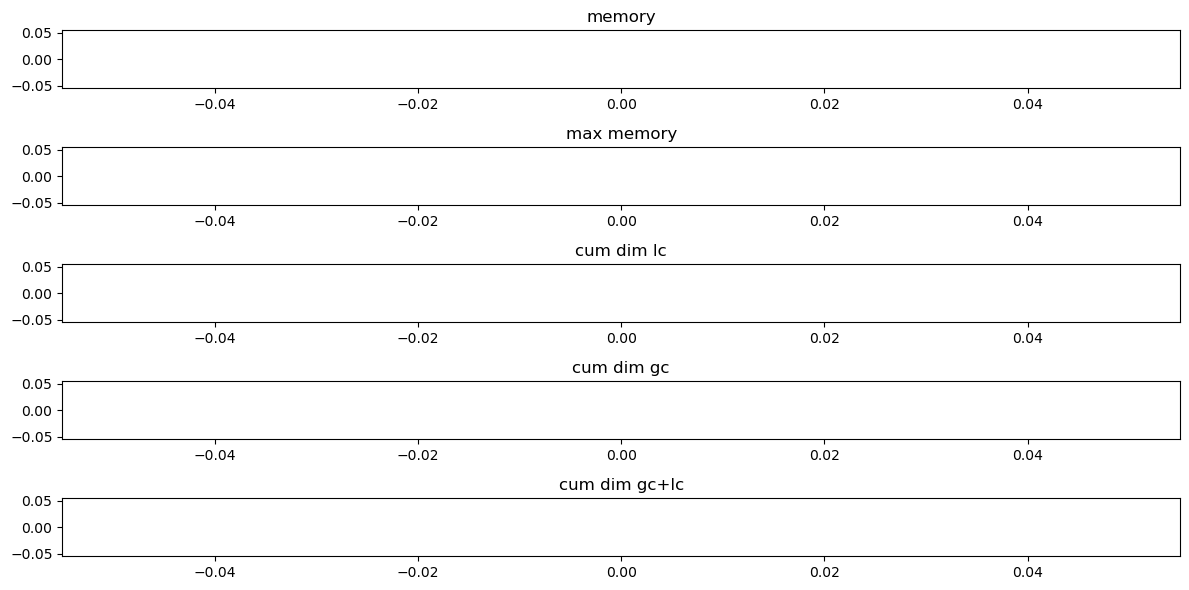

In [10]:
f, a = plt.subplots(5, 1)
f.set_size_inches(12,6)
a[0].set_title("memory")
a[0].plot(mem_list)
a[1].set_title("max memory")
a[1].plot(max_mem_list)
a[2].set_title("cum dim lc")
a[2].plot(shapes_list_lc)
a[3].set_title("cum dim gc")
a[3].plot(shapes_list_gc)
a[4].set_title("cum dim gc+lc")
a[4].plot([lc+gc for lc,gc in zip(shapes_list_lc,shapes_list_gc)])
plt.tight_layout()
plt.show()

In [11]:
import torch

a = torch.ones(4, 28, 384)

nb_patch_list = [1, 2, 4, 1]
cls_tokens = []
for nb_patch in nb_patch_list:

    cls_tokens.append(torch.ltensor(1, nb_patch, 384))
    

AttributeError: module 'torch' has no attribute 'ltensor'

In [ ]:
import torch

aa = torch.ones((8, 6, 129, 128))
torch.nn.functional.softmax(aa, dim=-1).shape

torch.Size([8, 6, 129, 128])

In [ ]:
class Attention(dim=384,
        num_heads= 8)

In [ ]:
(224 * 224 * 2 + 98 * 98 * 8)/(14*14)

904.0

In [ ]:
import torch
torch.tile(torch.Tensor(1, 98, 98), (8,1,1)).shape

torch.Size([8, 98, 98])

In [ ]:
(98 * 98 * 8) / (14 * 14)

392.0

In [ ]:
int((98 * 98 * 8) / 14)

5488

In [ ]:
for i in range(len(out)):
    for k in out[i].keys():
        if out[i][k] is not None:
            print(k, out[i][k].shape)

KeyError: 0

In [ ]:
import torch 
torch.ones(1)[None,None,:].shape

torch.Size([1, 1, 1])

In [ ]:
torch.tile(torch.arange(19), (8,1)).shape

torch.Size([8, 19])

In [ ]:
filtered_bboxes = torch.ones((8, 4))
torch.cat([
    filtered_bboxes[:, 2:3] - filtered_bboxes[:, :1],
    filtered_bboxes[:, 3:] - filtered_bboxes[:, 1:2],
],dim=1)



tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [ ]:
filtered_bboxes[:, 1:2].shape

torch.Size([8, 1])

In [ ]:
#x
294* 384

112896

In [ ]:
257* 384

98688

In [ ]:
97* 97* 384

3613056

In [ ]:
96384/384


251.0

In [ ]:
256 * 384

98304

In [ ]:
from torch import nn

crop_pos_embed = nn.functional.interpolate(
    torch.ones((1, 16,16,384)).permute(0, 3, 1, 2),
    mode="bicubic",
    size=(6, 6),
)
print(crop_pos_embed.shape)

torch.Size([1, 384, 6, 6])


In [ ]:
crop_pos_embed = torch.ones([1, 384, 6, 6])
crop_pos_embed = crop_pos_embed.permute(0, 2, 3, 1).view(1, -1, 384)
print(crop_pos_embed.shape)
# keep only pos_embeds of selected patches
crop_pos_embed = torch.index_select(
    crop_pos_embed.squeeze(),
    dim=0,
    index=torch.tensor([1, 3, 10]).long(),
)
print(f"crop_pos_embed {crop_pos_embed.shape}")
# torch.cat([class_pos_embed] + crop_pos_embed))

torch.Size([1, 36, 384])
crop_pos_embed torch.Size([3, 384])


In [ ]:
41.0+53.0+58.0+72.0+64.0

288.0